In [ ]:
!pip install mediapipe

# 1. Import

In [4]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using Mediapipe Holistic

In [5]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # drawing utils

In [6]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image.flags.writeable = False
    results = model. process(image)                 # Make prediction
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [7]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)    
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)    
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)    

In [8]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [ ]:
# Test OpenCV video
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(frame.shape)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
len(results.left_hand_landmarks.landmark)

In [ ]:
frame

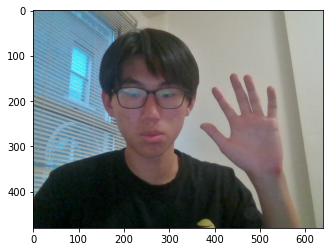

In [26]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [22]:
draw_styled_landmarks(frame,results)

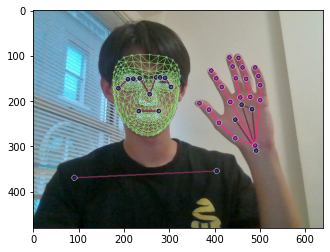

In [23]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoints Values

In [9]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [ ]:
result_test = extract_keypoints(results)

In [ ]:
result_test

# 4. Setup Folders for Manual Collection

In [10]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data_m') 

# Actions that we try to detect
# actions = []
# for folder in os.listdir(DATA_PATH):
#     if len(os.listdir(os.path.join(DATA_PATH, folder)))==0:
#         continue
#     else:
#         actions.append(folder)


# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 45 frames in length
sequence_length = 30

In [26]:
# Save action list into np array
np.save('actions_list.npy',actions)

In [11]:
# Load action list from np array
actions = np.load('actions_list.npy')

In [12]:
len(actions)

16

In [37]:
os.makedirs(DATA_PATH,exist_ok=True)
for action in actions:
    os.makedirs(os.path.join(DATA_PATH, action),exist_ok=True)

In [38]:
for action in actions: 
    for sequence in range(1,no_sequences+1):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Data Locally

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(1,no_sequences+1):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

# 6. Use downloaded dataset

In [9]:
root = 'C:\\Users\\ryanr\\ASLtoEng\\'
MP_DATA_PATH = os.path.join(root,'MP_Data_MSASL')

In [ ]:
for label in os.listdir(MP_DATA_PATH):
    LABEL_PATH = os.path.join(MP_DATA_PATH,label)
    for filename in os.listdir(LABEL_PATH):
        if filename.endswith('.mp4'):
            print(f'Reading {filename}...')
            
            video_name = filename.split('.')[0]
            VIDEO_PATH = os.path.join(LABEL_PATH,filename)
            VIDEO_FOLDER_PATH = os.path.join(LABEL_PATH,video_name)
#             VIDEO_FOLDER_PATH_FLIPPED = os.path.join(LABEL_PATH,video_name+"(1)")
            os.makedirs(VIDEO_FOLDER_PATH,exist_ok=True)
#             os.makedirs(VIDEO_FOLDER_PATH_FLIPPED,exist_ok=True)
            
            # Capture video
            vidcap = cv2.VideoCapture(VIDEO_PATH)
            # Set mediapipe model 
            with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

                # Read feed
                success, frame = vidcap.read()
                
                frame_num = 0
                
                while success:
                    # Make detections
                    image, results = mediapipe_detection(frame, holistic)
#                     image_flipped, results_flipped = mediapipe_detection(cv2.flip(frame, 1), holistic)
#                     image_flipped, results_flipped = mediapipe_detection(frame, holistic)

                    
#                     Draw detections for debugging
#                     draw_styled_landmarks(image, results)
#                     cv2.imshow('OpenCV Feed', image)
#                     cv2.waitKey(10)         
            
#                     draw_styled_landmarks(image_flipped, results_flipped)
#                     cv2.imshow('OpenCV Feed', image_flipped)
                    
                    # Export keypoints
                    keypoints = extract_keypoints(results)
                    npy_path = os.path.join(VIDEO_FOLDER_PATH, str(frame_num))
                    np.save(npy_path, keypoints)
                    
#                     keypoints_flipped = extract_keypoints(results_flipped)
#                     npy_path_flipped = os.path.join(VIDEO_FOLDER_PATH_FLIPPED, str(frame_num))
#                     np.save(npy_path_flipped, keypoints_flipped)
                         
                    success,frame = vidcap.read()
                    frame_num += 1
            
                    # Break gracefully
#                     if cv2.waitKey(10) & 0xFF == ord('q'):
#                         break
                
                print('Converted.')                    
                        
                # Break gracefully
#                 if cv2.waitKey(10) & 0xFF == ord('q'):
#                     break
            
            # close the video
            vidcap.release()
            
cv2.destroyAllWindows()        

In [87]:
import shutil

In [ ]:
# remove videos after converting
for label in os.listdir(MP_DATA_PATH):
    LABEL_PATH = os.path.join(MP_DATA_PATH,label)
    for filename in os.listdir(LABEL_PATH):
        if filename.endswith('.mp4'):
#         if filename.startswith('fast_') and filename.endswith('(1)'):
            filepath = os.path.join(LABEL_PATH,filename)
            print(f'Deleting {filename}...')
            os.remove(filepath)
#             shutil.rmtree(filepath)

In [ ]:
# sanity check that the data collected is correct
for label in os.listdir(MP_DATA_PATH):
    LABEL_PATH = os.path.join(MP_DATA_PATH,label)
    for filename in os.listdir(LABEL_PATH):
        if not filename.endswith('.mp4'):
            for npfile in os.listdir(os.path.join(LABEL_PATH,filename)):
                print(np.load(os.path.join(LABEL_PATH,filename,npfile)))
                break

# 6.* Preprocess Data and Create Labels and Features

In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
label_map = {label:num for num, label in enumerate(actions)}
print(label_map)

In [15]:
sequences, labels = [], []
for action in label_map.keys():
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))):
        window = []
        last_frame = 0
        for frame_num in range(sequence_length):
            if  os.path.exists(os.path.join(DATA_PATH, action, sequence, "{}.npy".format(frame_num))): 
                res = np.load(os.path.join(DATA_PATH, action, sequence, "{}.npy".format(frame_num)))
                last_frame = frame_num
            else: # if the video length is shorter than sequence length, need to pad
#                 res = np.zeros((1662,),dtype='float64') # zero padding
                res = np.load(os.path.join(DATA_PATH, action, sequence, "{}.npy".format(last_frame))) # last frame padding
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [17]:
X = np.array(sequences)

In [18]:
X.shape

(480, 30, 1662)

In [19]:
# Save X to be used later
np.save('cached_data/X_data_m',X)

In [20]:
y = to_categorical(labels,num_classes=len(actions)).astype(int)
# y = to_categorical(labels).astype(int)

In [21]:
# Save y so you can use later
np.save('cached_data/y_data_m',y)

In [22]:
y.shape

(480, 16)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [24]:
y_train.sum(axis=0)

array([27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27])

# 7. Build and Train LSTM Neural Network

In [69]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

In [26]:
# Tensorboard callback
log_dir = os.path.join('Logs/data_m')
tb_callback = TensorBoard(log_dir=log_dir)

In [43]:
# Saving checkpoint callback
checkpoint_path = os.path.join("Logs","data_m",'checkpoints','cp-{epoch:04d}.ckpt')
cp_callback = ModelCheckpoint(filepath=checkpoint_path,verbose=1,save_weights_only=True,save_freq=50*14)

In [ ]:
model = Sequential()
model.add(LSTM(16, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(32, return_sequences=True, activation='relu'))
model.add(LSTM(16, return_sequences=False, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(actions), activation='softmax'))

In [45]:
# Select optimizer
# opt = SGD(learning_rate=0.01,momentum=0.9)
opt = Adam(learning_rate=0.00005)
# opt = 'Adam'

In [46]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [62]:
# Load previous checkpoints
model.load_weights(os.path.join("Logs","data_m",'checkpoints','cp-0500.ckpt'))

In [63]:
model.fit(X_train, y_train, epochs=1500, callbacks=[cp_callback])

Epoch 1/1500
14/14 [==============================] - 3s 191ms/step - loss: 1.8943 - categorical_accuracy: 0.3218
Epoch 2/1500
14/14 [==============================] - 3s 203ms/step - loss: 1.8790 - categorical_accuracy: 0.3287
Epoch 3/1500
14/14 [==============================] - 3s 211ms/step - loss: 1.8787 - categorical_accuracy: 0.3241
Epoch 4/1500
14/14 [==============================] - 3s 213ms/step - loss: 1.8692 - categorical_accuracy: 0.3634
Epoch 5/1500
14/14 [==============================] - 3s 213ms/step - loss: 1.8316 - categorical_accuracy: 0.3565
Epoch 6/1500
14/14 [==============================] - 3s 244ms/step - loss: 1.8425 - categorical_accuracy: 0.3634
Epoch 7/1500
14/14 [==============================] - 3s 217ms/step - loss: 1.8206 - categorical_accuracy: 0.3588
Epoch 8/1500
14/14 [==============================] - 3s 199ms/step - loss: 1.8136 - categorical_accuracy: 0.3542
Epoch 9/1500
14/14 [==============================] - 3s 202ms/step - loss: 1.8389 - cat

Epoch 71/1500
14/14 [==============================] - 3s 206ms/step - loss: 1.3887 - categorical_accuracy: 0.4745
Epoch 72/1500
14/14 [==============================] - 3s 220ms/step - loss: 1.3794 - categorical_accuracy: 0.4907
Epoch 73/1500
14/14 [==============================] - 3s 212ms/step - loss: 1.4016 - categorical_accuracy: 0.4606
Epoch 74/1500
14/14 [==============================] - 3s 188ms/step - loss: 1.3311 - categorical_accuracy: 0.5046
Epoch 75/1500
14/14 [==============================] - 3s 196ms/step - loss: 1.3856 - categorical_accuracy: 0.5093
Epoch 76/1500
14/14 [==============================] - 3s 200ms/step - loss: 1.3846 - categorical_accuracy: 0.5069
Epoch 77/1500
14/14 [==============================] - 3s 206ms/step - loss: 1.5090 - categorical_accuracy: 0.4653
Epoch 78/1500
14/14 [==============================] - 3s 202ms/step - loss: 1.3506 - categorical_accuracy: 0.5255
Epoch 79/1500
14/14 [==============================] - 3s 204ms/step - loss: 1.3

14/14 [==============================] - 3s 196ms/step - loss: 1.0448 - categorical_accuracy: 0.6204
Epoch 209/1500
14/14 [==============================] - 3s 195ms/step - loss: 1.0564 - categorical_accuracy: 0.6273
Epoch 210/1500
14/14 [==============================] - 3s 189ms/step - loss: 1.0360 - categorical_accuracy: 0.6042
Epoch 211/1500
14/14 [==============================] - 3s 195ms/step - loss: 1.0195 - categorical_accuracy: 0.6296
Epoch 212/1500
14/14 [==============================] - 3s 212ms/step - loss: 1.0581 - categorical_accuracy: 0.5995
Epoch 213/1500
14/14 [==============================] - 3s 200ms/step - loss: 1.0379 - categorical_accuracy: 0.6042
Epoch 214/1500
14/14 [==============================] - 3s 189ms/step - loss: 1.0002 - categorical_accuracy: 0.6366
Epoch 215/1500
14/14 [==============================] - 3s 226ms/step - loss: 0.9898 - categorical_accuracy: 0.6343
Epoch 216/1500
14/14 [==============================] - 3s 241ms/step - loss: 0.9811 - 

14/14 [==============================] - 4s 252ms/step - loss: 0.5243 - categorical_accuracy: 0.8241
Epoch 346/1500
14/14 [==============================] - 4s 270ms/step - loss: 0.5281 - categorical_accuracy: 0.8102
Epoch 347/1500
14/14 [==============================] - 4s 255ms/step - loss: 0.5091 - categorical_accuracy: 0.8403
Epoch 348/1500
14/14 [==============================] - 3s 217ms/step - loss: 0.5479 - categorical_accuracy: 0.8009
Epoch 349/1500
14/14 [==============================] - 3s 226ms/step - loss: 0.5297 - categorical_accuracy: 0.8171
Epoch 350/1500
14/14 [==============================] - 3s 230ms/step - loss: 0.5267 - categorical_accuracy: 0.7870
Epoch 351/1500
14/14 [==============================] - 3s 237ms/step - loss: 0.5851 - categorical_accuracy: 0.8009
Epoch 352/1500
14/14 [==============================] - 3s 244ms/step - loss: 0.6335 - categorical_accuracy: 0.7639
Epoch 353/1500
14/14 [==============================] - 3s 208ms/step - loss: 0.6718 - 

14/14 [==============================] - 3s 223ms/step - loss: 0.3211 - categorical_accuracy: 0.9190
Epoch 484/1500
14/14 [==============================] - 3s 211ms/step - loss: 0.3007 - categorical_accuracy: 0.9190
Epoch 485/1500
14/14 [==============================] - 3s 200ms/step - loss: 0.3876 - categorical_accuracy: 0.8819
Epoch 486/1500
14/14 [==============================] - 3s 189ms/step - loss: 0.4191 - categorical_accuracy: 0.8519
Epoch 487/1500
14/14 [==============================] - 3s 185ms/step - loss: 0.4155 - categorical_accuracy: 0.8472
Epoch 488/1500
14/14 [==============================] - 3s 197ms/step - loss: 0.3332 - categorical_accuracy: 0.9051
Epoch 489/1500
14/14 [==============================] - 3s 197ms/step - loss: 0.3788 - categorical_accuracy: 0.8912
Epoch 490/1500
14/14 [==============================] - 3s 197ms/step - loss: 0.4780 - categorical_accuracy: 0.8356
Epoch 491/1500
14/14 [==============================] - 3s 193ms/step - loss: 0.6675 - 

14/14 [==============================] - 3s 191ms/step - loss: 0.3650 - categorical_accuracy: 0.8912
Epoch 552/1500
14/14 [==============================] - 3s 199ms/step - loss: 0.3119 - categorical_accuracy: 0.9005
Epoch 553/1500
14/14 [==============================] - 3s 210ms/step - loss: 0.2817 - categorical_accuracy: 0.9259
Epoch 554/1500
14/14 [==============================] - 3s 204ms/step - loss: 0.2924 - categorical_accuracy: 0.9074
Epoch 555/1500
14/14 [==============================] - 3s 199ms/step - loss: 0.3232 - categorical_accuracy: 0.8958
Epoch 556/1500
14/14 [==============================] - 3s 189ms/step - loss: 0.2929 - categorical_accuracy: 0.9190
Epoch 557/1500
14/14 [==============================] - 3s 194ms/step - loss: 0.3007 - categorical_accuracy: 0.9120
Epoch 558/1500
14/14 [==============================] - 3s 194ms/step - loss: 0.2938 - categorical_accuracy: 0.9120
Epoch 559/1500
14/14 [==============================] - 3s 203ms/step - loss: 0.2673 - 

14/14 [==============================] - 3s 200ms/step - loss: 0.1967 - categorical_accuracy: 0.9306
Epoch 690/1500
14/14 [==============================] - 3s 205ms/step - loss: 0.2626 - categorical_accuracy: 0.9074
Epoch 691/1500
14/14 [==============================] - 3s 208ms/step - loss: 0.2313 - categorical_accuracy: 0.9144
Epoch 692/1500
12/14 [========================>.....] - ETA: 0s - loss: 0.1900 - categorical_accuracy: 0.9323
Epoch 692: saving model to Logs\data_m\checkpoints\cp-0692.ckpt
14/14 [==============================] - 3s 228ms/step - loss: 0.1999 - categorical_accuracy: 0.9306
Epoch 693/1500
14/14 [==============================] - 3s 189ms/step - loss: 0.1396 - categorical_accuracy: 0.9630
Epoch 694/1500
14/14 [==============================] - 3s 206ms/step - loss: 0.1399 - categorical_accuracy: 0.9699
Epoch 695/1500
14/14 [==============================] - 3s 186ms/step - loss: 0.1426 - categorical_accuracy: 0.9676
Epoch 696/1500
14/14 [======================

14/14 [==============================] - 3s 243ms/step - loss: 0.0941 - categorical_accuracy: 0.9861
Epoch 758/1500
14/14 [==============================] - 3s 214ms/step - loss: 0.0996 - categorical_accuracy: 0.9815
Epoch 759/1500
14/14 [==============================] - 3s 202ms/step - loss: 0.1047 - categorical_accuracy: 0.9745
Epoch 760/1500
14/14 [==============================] - 3s 188ms/step - loss: 0.0956 - categorical_accuracy: 0.9815
Epoch 761/1500
14/14 [==============================] - 3s 195ms/step - loss: 0.1332 - categorical_accuracy: 0.9630
Epoch 762/1500
14/14 [==============================] - 3s 216ms/step - loss: 0.1165 - categorical_accuracy: 0.9745
Epoch 763/1500
14/14 [==============================] - 3s 198ms/step - loss: 0.0974 - categorical_accuracy: 0.9838
Epoch 764/1500
14/14 [==============================] - 3s 212ms/step - loss: 0.1074 - categorical_accuracy: 0.9722
Epoch 765/1500
14/14 [==============================] - 3s 202ms/step - loss: 0.1257 - 

14/14 [==============================] - 3s 208ms/step - loss: 0.0653 - categorical_accuracy: 0.9907
Epoch 895/1500
14/14 [==============================] - 3s 207ms/step - loss: 0.0583 - categorical_accuracy: 0.9931
Epoch 896/1500
14/14 [==============================] - 3s 225ms/step - loss: 0.0554 - categorical_accuracy: 0.9954
Epoch 897/1500
14/14 [==============================] - 3s 208ms/step - loss: 0.0605 - categorical_accuracy: 0.9954
Epoch 898/1500
14/14 [==============================] - 3s 207ms/step - loss: 0.0756 - categorical_accuracy: 0.9884
Epoch 899/1500
14/14 [==============================] - 3s 202ms/step - loss: 0.0691 - categorical_accuracy: 0.9884
Epoch 900/1500
14/14 [==============================] - 3s 210ms/step - loss: 0.0721 - categorical_accuracy: 0.9884
Epoch 901/1500
14/14 [==============================] - 3s 206ms/step - loss: 0.1559 - categorical_accuracy: 0.9560
Epoch 902/1500
14/14 [==============================] - 3s 206ms/step - loss: 0.2506 - 

14/14 [==============================] - 3s 221ms/step - loss: 0.0500 - categorical_accuracy: 0.9977
Epoch 1033/1500
14/14 [==============================] - 3s 210ms/step - loss: 0.0542 - categorical_accuracy: 0.9954
Epoch 1034/1500
14/14 [==============================] - 3s 188ms/step - loss: 0.0547 - categorical_accuracy: 0.9977
Epoch 1035/1500
14/14 [==============================] - 3s 215ms/step - loss: 0.0826 - categorical_accuracy: 0.9861
Epoch 1036/1500
14/14 [==============================] - 3s 197ms/step - loss: 0.0847 - categorical_accuracy: 0.9769
Epoch 1037/1500
14/14 [==============================] - 3s 191ms/step - loss: 0.0682 - categorical_accuracy: 0.9907
Epoch 1038/1500
14/14 [==============================] - 3s 193ms/step - loss: 0.0621 - categorical_accuracy: 0.9931
Epoch 1039/1500
14/14 [==============================] - 3s 196ms/step - loss: 0.0454 - categorical_accuracy: 0.9977
Epoch 1040/1500
14/14 [==============================] - 3s 200ms/step - loss: 0

14/14 [==============================] - 3s 216ms/step - loss: 0.1342 - categorical_accuracy: 0.9491
Epoch 1168/1500
14/14 [==============================] - 3s 211ms/step - loss: 0.1296 - categorical_accuracy: 0.9560
Epoch 1169/1500
14/14 [==============================] - 3s 192ms/step - loss: 0.0853 - categorical_accuracy: 0.9745
Epoch 1170/1500
14/14 [==============================] - 3s 189ms/step - loss: 0.0740 - categorical_accuracy: 0.9769
Epoch 1171/1500
14/14 [==============================] - 3s 209ms/step - loss: 0.0416 - categorical_accuracy: 0.9907
Epoch 1172/1500
14/14 [==============================] - 3s 202ms/step - loss: 0.0339 - categorical_accuracy: 0.9977
Epoch 1173/1500
14/14 [==============================] - 3s 226ms/step - loss: 0.0375 - categorical_accuracy: 0.9931
Epoch 1174/1500
14/14 [==============================] - 3s 205ms/step - loss: 0.0329 - categorical_accuracy: 0.9977
Epoch 1175/1500
14/14 [==============================] - 3s 228ms/step - loss: 0

KeyboardInterrupt: 

In [ ]:
model.summary()

# 8. Make Predictions

In [50]:
res = model.predict(X_test)
res.shape

(48, 16)

In [ ]:
actions[np.argmax(res[2])]

In [ ]:
actions[np.argmax(y_test[2])]

# 9. Save Weights

In [60]:
# Save h5 file (weights only)
model.save('weights/action_data_m_0.70.h5')

In [71]:
# Save keras model (model only)
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [59]:
del model

In [67]:
# Loading weights given keras model
model.load_weights('weights/action_data_m_0.70.h5')

In [70]:
# Save keras model & weights to saved_model folder
tensorflow.saved_model.save(model,'saved_model/1')

INFO:tensorflow:Assets written to: saved_model/1\assets


# 10. Evaluation using Confusion Matrix and Accuracy

In [53]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [54]:
yhat = model.predict(X_test)

In [56]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

In [ ]:
accuracy_score(ytrue, yhat)

# 11. Test in Real Time

In [174]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num%3], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        # print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-sequence_length:]
        
        if len(sequence) == sequence_length:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 4: 
                sentence = sentence[-4:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()